# **Flight Prices - EDA**

## **Load librares/dataset, clean up dataset and feature engineering**

In [9]:
# Install libraries

# sklearn (scikit-learn?)
# xgboost
# shap
# pickle
# itertools

In [1]:
# Import libraries
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from xgboost import XGBRegressor
import shap
import pickle
from sklearn.model_selection import train_test_split
import itertools
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning) #ignore all future warnings

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [11]:
# Apply the default theme to seaborn and activate color codes
sns.set_theme()
sns.set(color_codes=True)

In [12]:
import pandas as pd
# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/imads20/BDS23/main/M1_Final_Assignment/business.csv")
# Print first five rows:
df.head()

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,"25,612"
1,11-02-2022,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,"25,612"
2,11-02-2022,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,"42,220"
3,11-02-2022,Air India,AI,839,21:25,Delhi,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"44,450"
4,11-02-2022,Air India,AI,544,17:15,Delhi,06h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"46,690"


In [13]:
# Print columns names and types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93487 entries, 0 to 93486
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        93487 non-null  object
 1   airline     93487 non-null  object
 2   ch_code     93487 non-null  object
 3   num_code    93487 non-null  int64 
 4   dep_time    93487 non-null  object
 5   from        93487 non-null  object
 6   time_taken  93487 non-null  object
 7   stop        93487 non-null  object
 8   arr_time    93487 non-null  object
 9   to          93487 non-null  object
 10  price       93487 non-null  object
dtypes: int64(1), object(10)
memory usage: 7.8+ MB


From the above we can see that most of the columns are objects and we only have one numerical columns. 
When comparing the column type to the column name, there are several of the columns that we would expect to contain numerical values even through they are caegorized as objects - for instance 'time_taken', 'stop', and 'price'. 

Further, we would also like to have a variable for the distance between the places. Likewise, we would also like to group the departure time and arrival time into bins. 
This means that we have some cleaning up to do with the dataset.

In [14]:
# Convert time_taken to number of minutes taken

# From the head() above, we can see that time_taken is formatted like '02h 00m'.
# Converting this format to number of minutes is a bit tedious, so we build a function to help us

# Function for converting the hour-minute format to minutes
def convert_to_minutes(time_str):
    hours, minutes_str = time_str.split('h ')   # Take the time string and split it by 'h '.
                                                # This will split the string into two parts:
                                                # The first part will correspond to the hours number of hours
                                                # The second part will be the number of minutes

    minutes = minutes_str.replace("m", "") # Replace the 'm' in the minutes with nothing

    hours = int(hours) # Convert hours and minutes to integers
    minutes = int(minutes)

    total_minutes = (hours * 60) + minutes # Find the total number of minutes

    return total_minutes

# Apply the function defined above to the column
df['duration_minutes'] = df['time_taken'].apply(convert_to_minutes)
df['duration_minutes'][:5] # Print the first 5 rows as control

0     120
1     135
2    1485
3    1590
4     400
Name: duration_minutes, dtype: int64

In [15]:
# Convert stop to number of stops

# Looking at the head() above, the stop column seems to be defined in an interesting manner.
# In order to get an overview of the formatting, we can print the unique values in the column:
df['stop'].unique()

array(['non-stop ',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IDR\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IXU\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Chennai\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Lucknow\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia STV\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Hyderabad\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia GAY\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '2+-stop',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Guwahati\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia GAU\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia VTZ\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia NDC\n\t\t\t\t\t\t\t\t\t\t\t\t',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t

In [16]:
# The columns contains number of stops as well as the location of the stop.
# The number of stops can either be zero, one, or more than two. 

# Function for defining number of stops
def number_of_stops(string):
    stops_str = string.split('-stop')[0] # Split the string by '-stop' and keep only the first part of the split

    # Define what the number of stop is based on the string
    if stops_str == 'non':
        stops = 0
    elif stops_str == '1':
        stops = 1
    elif stops_str == '2+':
        stops = 2
    else: 
        stops = np.nan # if the format of the sting doesn't match the above, set it as nan

    return stops

# Apply the function defined above to the column
df['stop'] = df['stop'].apply(number_of_stops)
df['stop'][:5] # Control

0    0
1    0
2    1
3    1
4    1
Name: stop, dtype: int64

In [17]:
# Convert price to numeical value: 

# The head() above shows that price contains a ','.
# In order to convert the price to a numerical value, we need to remove this
df['price'] = df['price'].str.replace(",", "")

# Afterwards, convert the string to a number
df['price'] = df['price'].astype(int)
df['price'][:5] # Control

0    25612
1    25612
2    42220
3    44450
4    46690
Name: price, dtype: int64

In [18]:
# Create distance column:

# Define a list with distance between places
city_distances = {
    ('Delhi', 'Mumbai'): 1139,
    ('Delhi', 'Bangalore'): 1710,
    ('Delhi', 'Kolkata'): 1313,
    ('Delhi', 'Hyderabad'): 1268,
    ('Delhi', 'Chennai'): 1761,
    ('Mumbai', 'Bangalore'): 835,
    ('Mumbai', 'Kolkata'): 1666,
    ('Mumbai', 'Hyderabad'): 624,
    ('Mumbai', 'Chennai'): 1034,
    ('Bangalore', 'Kolkata'): 1547,
    ('Bangalore', 'Hyderabad'): 455,
    ('Bangalore', 'Chennai'): 268,
    ('Kolkata', 'Hyderabad'): 1208,
    ('Kolkata', 'Chennai'): 1386,
    ('Hyderabad', 'Chennai'): 507
}

# Function for finding distance between to and from
def calculate_distance(row):
    city1, city2 = row['from'], row['to'] # Define city1 and city2 based on from and to columns
    distance = city_distances.get((city1, city2), city_distances.get((city2, city1), None)) # Get the distance between the cities 
                                                                                            # regardless of the order of to and from
    return distance

df['distance'] = df.apply(calculate_distance, axis=1)
df.head() # Control

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,duration_minutes,distance
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,0,20:00,Mumbai,25612,120,1139
1,11-02-2022,Air India,AI,624,19:00,Delhi,02h 15m,0,21:15,Mumbai,25612,135,1139
2,11-02-2022,Air India,AI,531,20:00,Delhi,24h 45m,1,20:45,Mumbai,42220,1485,1139
3,11-02-2022,Air India,AI,839,21:25,Delhi,26h 30m,1,23:55,Mumbai,44450,1590,1139
4,11-02-2022,Air India,AI,544,17:15,Delhi,06h 40m,1,23:55,Mumbai,46690,400,1139


Night: 23:00-03:59
Early_morning: 04:00-06:59
Morning: 07:00-10:59
Midday: 11:00-13:59
Afternoon: 14:00-16:59
Evening: 17:00-19:59
Late_evening: 20:00-22:59

In [19]:
# Create bins for departure time and arrival time:

def group_time(time):
    group = None

    if time < '04:00':
        group = 'Night'
    elif time >= '04:00' and time < '07:00':
        group = 'Early_morning'
    elif time >= '07:00' and time < '11:00':
        group = 'Morning'
    elif time >= '11:00' and time < '14:00':
        group = 'Midday'
    elif time >= '14:00' and time < '17:00':
        group = 'Afternoon'
    elif time >= '17:00' and time < '20:00':
        group = 'Evening'
    elif time >= '20:00' and time < '23:00':
        group = 'Late_evening'
    elif time >= '23:00':
        group = 'Night'
    
    return group

# Apply the function
df['dep_time'] = df['dep_time'].apply(group_time)
df['arr_time'] = df['arr_time'].apply(group_time)
df.head() # Control

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,duration_minutes,distance
0,11-02-2022,Air India,AI,868,Evening,Delhi,02h 00m,0,Late_evening,Mumbai,25612,120,1139
1,11-02-2022,Air India,AI,624,Evening,Delhi,02h 15m,0,Late_evening,Mumbai,25612,135,1139
2,11-02-2022,Air India,AI,531,Late_evening,Delhi,24h 45m,1,Late_evening,Mumbai,42220,1485,1139
3,11-02-2022,Air India,AI,839,Late_evening,Delhi,26h 30m,1,Night,Mumbai,44450,1590,1139
4,11-02-2022,Air India,AI,544,Evening,Delhi,06h 40m,1,Night,Mumbai,46690,400,1139


In [20]:
# Only keep the columns we're going to use
df = df[['price', 'airline', 'from', 'to', 'dep_time', 'arr_time', 'distance', 'duration_minutes', 'stop']]
df.head()

,price,airline,from,to,dep_time,arr_time,distance,duration_minutes,stop
0,25612,Air India,Delhi,Mumbai,Evening,Late_evening,1139,120,0
1,25612,Air India,Delhi,Mumbai,Evening,Late_evening,1139,135,0
2,42220,Air India,Delhi,Mumbai,Late_evening,Late_evening,1139,1485,1
3,44450,Air India,Delhi,Mumbai,Late_evening,Night,1139,1590,1
4,46690,Air India,Delhi,Mumbai,Evening,Night,1139,400,1


### **Handling missing values**

Missing values, denoted as NaN (Not a Number) or null values, can be present in various features of a dataset due to a variety of reasons, such as data collection errors, incomplete records ect. 
Before working with any dataset it's also important to take care of any missing values. If left untrated, missing values can cause issues later in an analysis as not all algorthms can handle missing values. 

There are many ways to handle missing values, and the strategy depends on the nature of the variable:

- **For numerical values**: common strategies to handle missing values include: Replace missing values with the mean or median of the non-missing values in that column, or predicting the missing values using a regression model based on other features.

- **For numerical values**: common strategies to handle missing values include: Replace missing values with the mode of the non-missing values in that column.

Depending on the number of missing values, it might also make sense to remove the rows or columns with missing values. This is suitable when the proportion of missing values is small and won't significantly impact the analysis.

In [21]:
# Find the number of missing values in each column
df.isnull().sum()
# As seen from the below, there are no missing values in ths dataset, which means that there are no missing values to handle.

price               0
airline             0
from                0
to                  0
dep_time            0
arr_time            0
distance            0
duration_minutes    0
stop                0
dtype: int64

# **Performing EDA on the dataset**

Exploratory Data Analysis (EDA) is an essential initial step in data analysis. It involves thoroughly examining and understanding a dataset to derive insights and patterns. The primary objectives of EDA include understanding the dataset's composition, identifying anomalies, uncovering patterns and trends, exploring relationships and correlations between variables, identifying potential insights, informing data preprocessing needs, and guiding model selection and feature engineering. 

Through various visualization and statistical techniques, EDA helps in revealing underlying patterns, trends, or irregularities within the data. This includes distribution of variables, central tendencies, and dispersion.
EDA enables the exploration of relationships and correlations between variables, aiding in understanding how one variable might influence another. This is critical for feature selection and model building in machine learning.
Further, EDA informs the preprocessing steps needed to clean and prepare the data for modeling. This may involve scaling, encoding categorical variables, and more.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93487 entries, 0 to 93486
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             93487 non-null  int64 
 1   airline           93487 non-null  object
 2   from              93487 non-null  object
 3   to                93487 non-null  object
 4   dep_time          93487 non-null  object
 5   arr_time          93487 non-null  object
 6   distance          93487 non-null  int64 
 7   duration_minutes  93487 non-null  int64 
 8   stop              93487 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 6.4+ MB


<Axes: ylabel='price'>

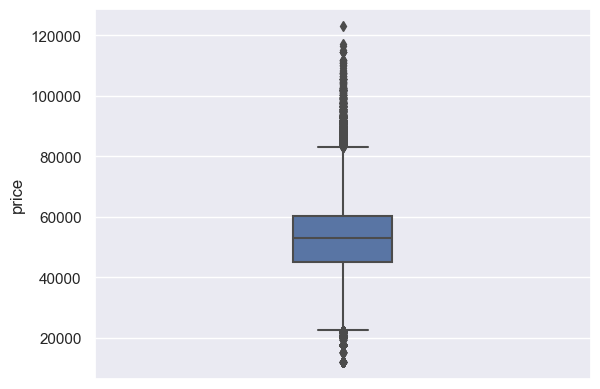

In [23]:
# Boxplot of price
sns.boxplot(y=df['price'], orient="v", width=0.2)
# From the boxplot we can see that we have some outliers in the price, so we will take care these by removing them.

<Axes: ylabel='price'>

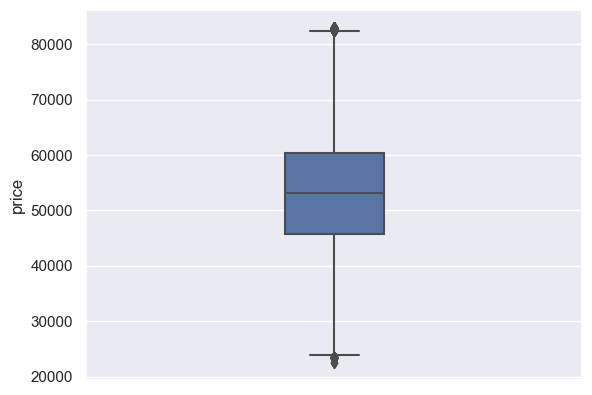

In [24]:
#Here we remove all the outliers from our dataset first we define the first quantile and the third quantile
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Create a mask to identify outliers
outlier = (df['price'] < (Q1 - 1.5 * IQR)) | (df['price'] > (Q3 + 1.5 * IQR))

# Remove outliers from the DataFrame
df = df[~outlier]
#Now we will plot and see the distribution of the variables:
sns.boxplot(y=df['price'], orient="v", width=0.2)

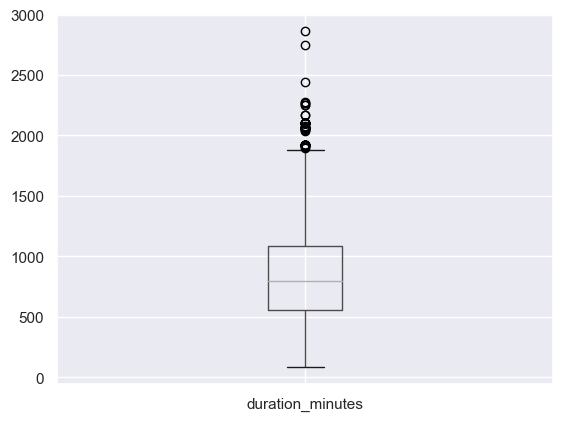

In [25]:
# Check for outliers on duration_minutes:
df.boxplot(column='duration_minutes')
plt.show()
# Again, we have some outliers, so we will remove these

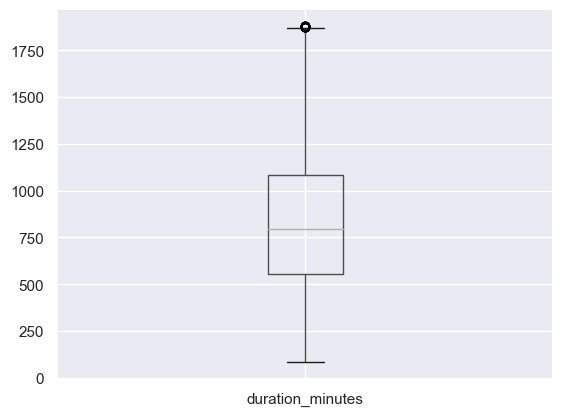

In [26]:
#Here we remove all the outliers from our dataset first we define the first quantile and the third quantile
Q1 = df['duration_minutes'].quantile(0.25)
Q3 = df['duration_minutes'].quantile(0.75)
IQR = Q3 - Q1

# Create a mask to identify outliers
outlier = (df['duration_minutes'] < (Q1 - 1.5 * IQR)) | (df['duration_minutes'] > (Q3 + 1.5 * IQR))

# Remove outliers from the DataFrame
df = df[~outlier]
#Now we will plot and see the distribution of the variables:
df.boxplot(column='duration_minutes')
plt.show()

<Axes: ylabel='distance'>

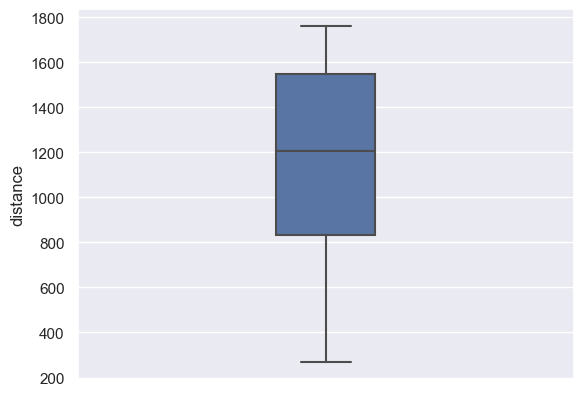

In [27]:
# Boxplot of price
sns.boxplot(y=df['distance'], orient="v", width=0.2)
# Here we have no outliers, so there is nothing to remove

The figure layout has changed to tight


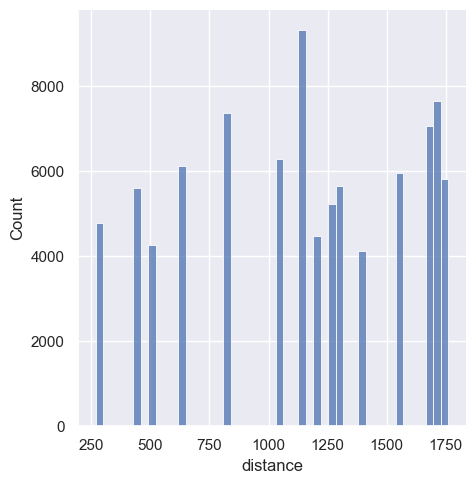

In [28]:
# Histogram of distances 
sns.displot(data=df,
            x='distance', 
            kind='hist')

The figure layout has changed to tight


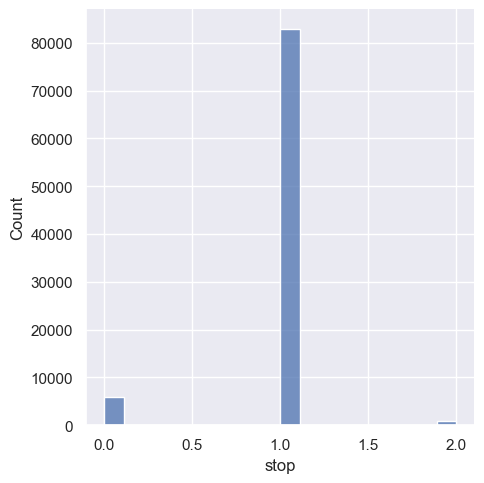

In [29]:
# Histogram of stop
sns.displot(data=df,
            x='stop', 
            kind='hist')

[Text(0.5, 1.0, 'Distribution of Airlines')]

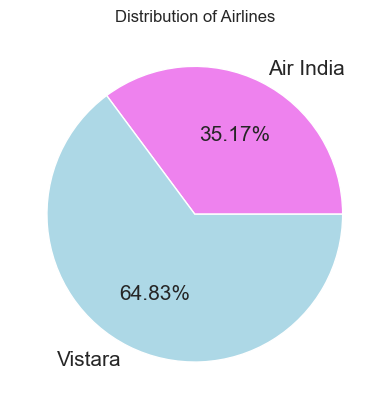

In [30]:
# Pie chart of airlines:
df.groupby('airline').size().plot(kind='pie', textprops={'fontsize': 15}, colors=['violet', 'lightblue'],
                                  autopct='%1.2f%%').set(title='Distribution of Airlines')

In [31]:
# We only have two airlines, so we will make this into a dummy variable using LabelEncoder
le = LabelEncoder()
df['airline'] = le.fit_transform(df['airline'])
df.head() #Control

,price,airline,from,to,dep_time,arr_time,distance,duration_minutes,stop
0,25612,0,Delhi,Mumbai,Evening,Late_evening,1139,120,0
1,25612,0,Delhi,Mumbai,Evening,Late_evening,1139,135,0
2,42220,0,Delhi,Mumbai,Late_evening,Late_evening,1139,1485,1
3,44450,0,Delhi,Mumbai,Late_evening,Night,1139,1590,1
4,46690,0,Delhi,Mumbai,Evening,Night,1139,400,1


The figure layout has changed to tight


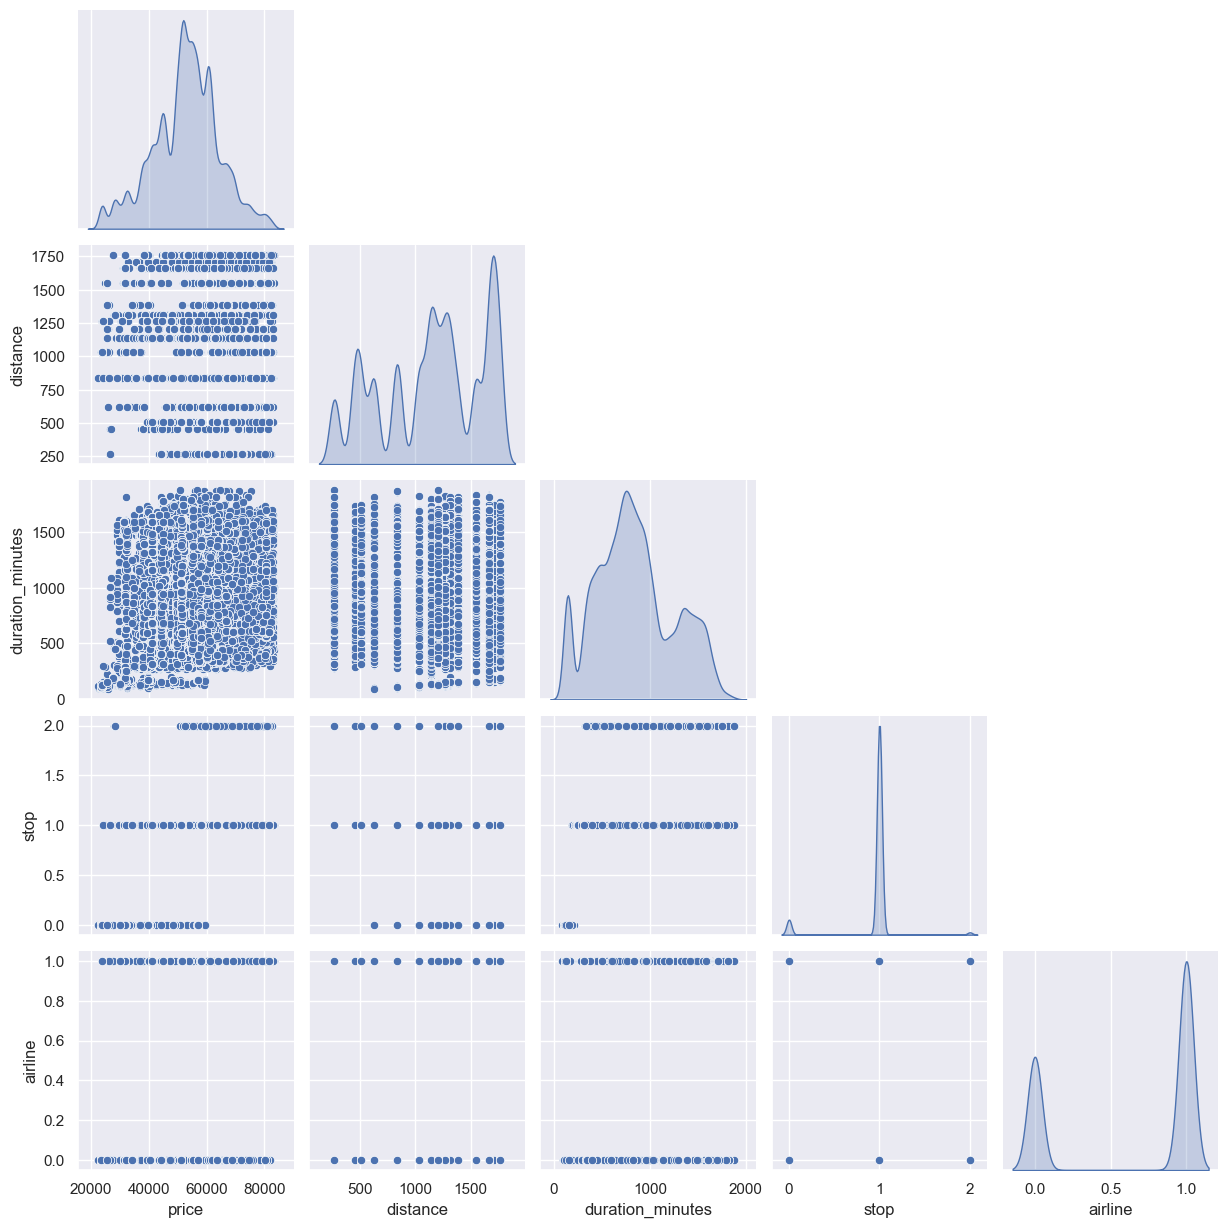

In [32]:
df_filtered = df[['price', 'distance', 'duration_minutes', 'stop', 'airline']] # Crate a df with only numerical columns
sns.pairplot(df_filtered, corner=True, 
             diag_kind='kde')

In [33]:
# Check how dataset looks now
df = df.reset_index(drop=True) # Reset the index of the df as we have removed some rows
df.info()
# We have removed roughly 4000 entries due to outliers. 
# Given the sample size, we consider this reasonable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89747 entries, 0 to 89746
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             89747 non-null  int64 
 1   airline           89747 non-null  int64 
 2   from              89747 non-null  object
 3   to                89747 non-null  object
 4   dep_time          89747 non-null  object
 5   arr_time          89747 non-null  object
 6   distance          89747 non-null  int64 
 7   duration_minutes  89747 non-null  int64 
 8   stop              89747 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 6.2+ MB


<Axes: >

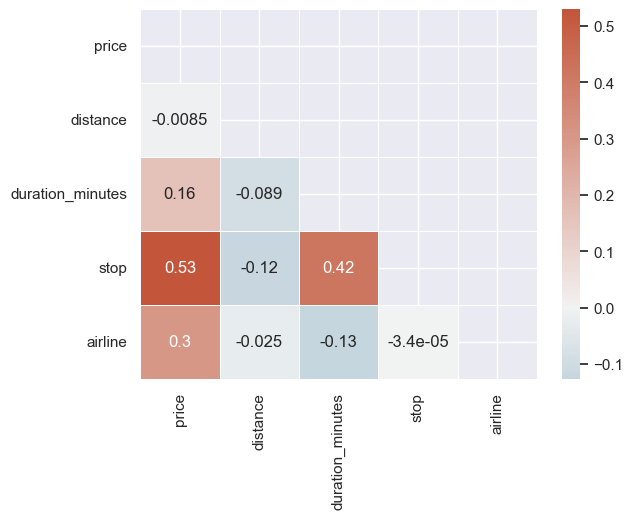

In [34]:
# Correlaton between the numcerical values: 
corr = df_filtered.corr() # Compute correlations coefficients in the dataset
cmap = sns.diverging_palette(230, 20, as_cmap=True) # Create a color palette for the heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))  # Create mask for upper triangle of correlation matrix
                                                # This is done to make the plot more simplistic
sns.heatmap(corr, mask=mask, cmap=cmap, # Apply the correlation matrix along with mask and color palette to the heatmap
            center=0, # Center the color palette around 0 (negative correlation will be blue and positive will be red)
            annot=True, # Write the correlations in the heatmap
            linewidth=0.5)

# **Scaling numerical variable and apply Encoders to categorical variables**

## **Scaling**

In [35]:
# We will scale our numerical columns (price, airline, distance, duration_minutes, stop) using the StandardScaler
df_num = df[['price', 'airline', 'distance', 'duration_minutes', 'stop']]
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_num.iloc[:,:])
df_num.iloc[:,:] = scaled_values
df_num.head() #control

,price,airline,distance,duration_minutes,stop
0,-2.414318,-1.357728,-0.00915,-1.798487,-3.494225
1,-2.414318,-1.357728,-0.00915,-1.760988,-3.494225
2,-0.941825,-1.357728,-0.00915,1.613916,0.206025
3,-0.744109,-1.357728,-0.00915,1.876408,0.206025
4,-0.545507,-1.357728,-0.00915,-1.098507,0.206025


## **Encoding**

In [36]:
# We will encode our categorical columns (to, from, dep_time, arr_time) using OneHotEncoder
df_cat = df[['to', 'from', 'dep_time', 'arr_time']]

# To prevent columns with the same name, we add a suffix to the variables
df_cat['to'] = 'to_' + df_cat['to']
df_cat['from'] = 'from_' + df_cat['from']
df_cat['dep_time'] = 'dep_' + df_cat['dep_time']
df_cat['arr_time'] = 'arr_' + df_cat['arr_time']

# Apply the OneHotEncoder
ohe_X = OneHotEncoder(sparse=False) 
X_ohe = ohe_X.fit_transform(df_cat.iloc[:,:]) 
columns_X_ohe = list(itertools.chain(*ohe_X.categories_)) # Get the column names
columns_X_ohe


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

['to_Bangalore',
 'to_Chennai',
 'to_Delhi',
 'to_Hyderabad',
 'to_Kolkata',
 'to_Mumbai',
 'from_Bangalore',
 'from_Chennai',
 'from_Delhi',
 'from_Hyderabad',
 'from_Kolkata',
 'from_Mumbai',
 'dep_Afternoon',
 'dep_Early_morning',
 'dep_Evening',
 'dep_Late_evening',
 'dep_Midday',
 'dep_Morning',
 'dep_Night',
 'arr_Afternoon',
 'arr_Early_morning',
 'arr_Evening',
 'arr_Late_evening',
 'arr_Midday',
 'arr_Morning',
 'arr_Night']

In [37]:
df_cat = pd.DataFrame(X_ohe, columns = columns_X_ohe)
df_cat.head()

,to_Bangalore,to_Chennai,to_Delhi,to_Hyderabad,to_Kolkata,to_Mumbai,from_Bangalore,from_Chennai,from_Delhi,from_Hyderabad,...,dep_Midday,dep_Morning,dep_Night,arr_Afternoon,arr_Early_morning,arr_Evening,arr_Late_evening,arr_Midday,arr_Morning,arr_Night
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## **Combine dataframes**

In [38]:
df_combined = pd.merge(df_num, df_cat, left_index=True, right_index=True, how='left')
df_combined.head()

,price,airline,distance,duration_minutes,stop,to_Bangalore,to_Chennai,to_Delhi,to_Hyderabad,to_Kolkata,...,dep_Midday,dep_Morning,dep_Night,arr_Afternoon,arr_Early_morning,arr_Evening,arr_Late_evening,arr_Midday,arr_Morning,arr_Night
0,-2.414318,-1.357728,-0.00915,-1.798487,-3.494225,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-2.414318,-1.357728,-0.00915,-1.760988,-3.494225,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.941825,-1.357728,-0.00915,1.613916,0.206025,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.744109,-1.357728,-0.00915,1.876408,0.206025,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.545507,-1.357728,-0.00915,-1.098507,0.206025,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# **Unsupervised Machine Learning**

## **Dimensionality Reduction (PCA)**

Principal Component Analysis (PCA) is a valuable technique for reducing dimensionality in datasets with mostly numerical variables. However, it is not ideal for datasets primarily composed of categorical variables with only a few numerical columns. In such cases, using PCA can lead to data distortion, loss of interpretability, and a limited understanding of the categorical variables.

In [39]:
pca = PCA(n_components=2)
pca.fit(df_combined)
reduced_df = pca.transform(df_combined)

<Axes: >

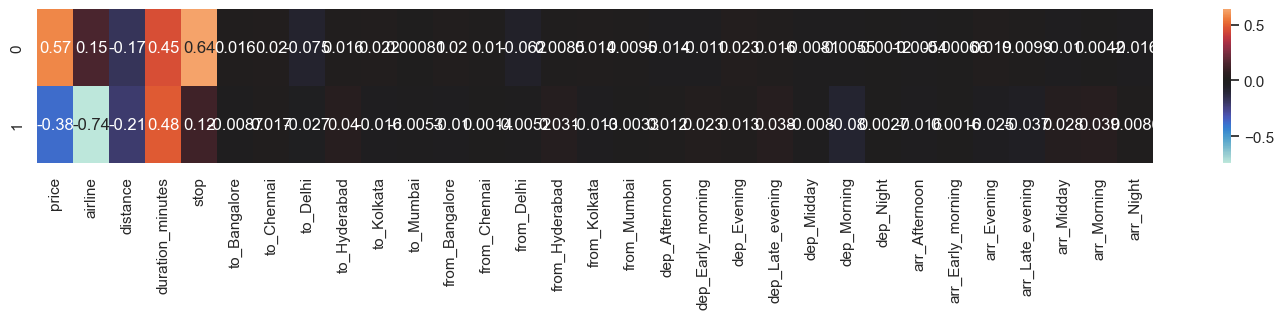

In [40]:
plt.figure(figsize=(18,2))
sns.heatmap(pd.DataFrame(pca.components_, columns=df_combined.columns), annot=True, center = 0)

In [41]:
print(pca.explained_variance_ratio_)
# After out dimensionality reduction, we can explain roughly 37% of the 
# variation in the dataset

[0.22024465 0.14970637]


<Axes: >

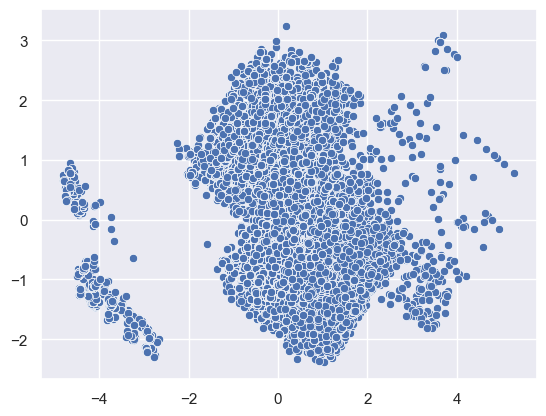

In [42]:
sns.scatterplot(x=reduced_df[:,0], y=reduced_df[:,1])

## **Clustering (K-means)**

Using clustering in our project may not be the best approach. Firstly, our dataset has a high dimensionality with numerous columns, primarily due to one-hot encoding categorical variables. Clustering works better with more data. Secondly, we face limitations in terms of data variation. If our dataset lacks diversity and meaningful patterns, clustering might not provide valuable insights.

Considering these challenges, it's advisable to explore alternative methods that better suit our dataset and project goals.

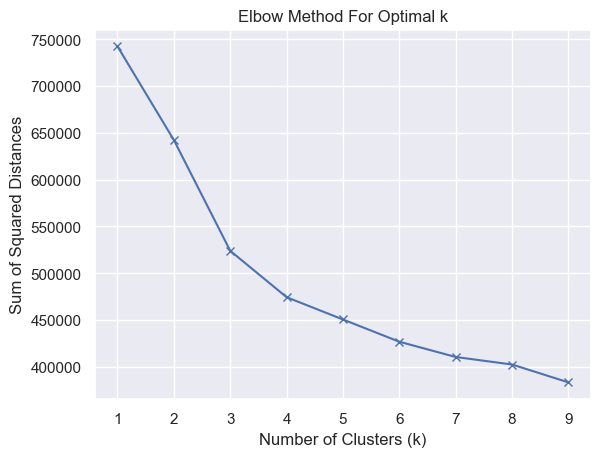

In [43]:
# To determine number of cluster we will use the elbow-method
Sum_of_squared_distances = []

# Define a range for possible cluster values (1 to 9)
K = range(1, 10)

# For each possible 'k', fit a KMeans model and compute the sum of squared distances
for k in K:
    km = KMeans(n_clusters=k, n_init = "auto")
    km.fit(df_combined)
    Sum_of_squared_distances.append(km.inertia_)

# Plot the sum of squared distances for each 'k' to determine the 'elbow'
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.grid(True)  # Add a grid for better visualization
plt.show()
# Looking at the plot, we should have 4 clusters

Cluster centroids:
 [[ 1.21767807 -0.40622121]
 [-0.06026174  1.22100678]
 [ 0.10771177 -0.9498763 ]
 [-4.26143582 -0.64640819]]


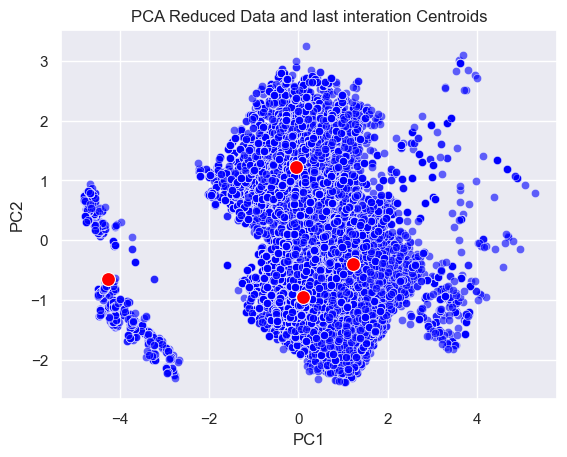

In [44]:
max_iters=1000
k = 4

centroids = reduced_df[np.random.choice(df.shape[0], k, replace=False)]

def k_means_simple(data, k, max_iters=100):
    # 1. Initialize the k cluster centroids
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]

    for _ in range(max_iters):
        # 2. Assign each data point to the closest centroid
        distances = np.linalg.norm(data - centroids[:, np.newaxis], axis=2)
        labels = np.argmin(distances, axis=0)

        # 3. Recompute the centroids
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])

        # Check for convergence
        if np.all(centroids == new_centroids):
            break #if the centers doesn't get better, there's no need to continue running

        centroids = new_centroids

    return labels, centroids

# Then use the function
labels, final_centroids = k_means_simple(reduced_df, k, max_iters)
print("Cluster centroids:\n", final_centroids)

# Plot observations after 100st interation
sns.scatterplot(x=reduced_df[:, 0], y=reduced_df[:, 1], alpha=0.6, color='blue')

# Plot centroids
sns.scatterplot(x=final_centroids[:, 0], y=final_centroids[:, 1], color='red', s=100)
plt.title('PCA Reduced Data and last interation Centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# **Supervised Machine Learning**

In this assignment, we aim to predict flight prices through supervised machine learning techniques. Initially, we divide the dataset into features and a target variable for the flight fares. 
To ensure an unbiased evaluation of our models' performance, we divide the dataset into training and testing sets. The training set allows our models to learn patterns and relationships, while the testing set serves as an unseen dataset for assessing their generalization capabilities. Employing LinearRegression as a baseline, we compute the R-squared ($R^2$) metric and Root Mean Squared Error (RMSE) on both the training and testing sets to gauge the performance of this linear regression model. Subsequently, we extend our analysis to RandomForest and XGBoost models, employing the same evaluation metrics to compare their predictive abilities and select the optimal approach for predicting flight prices.

In [45]:
# First we split the data into features (X) and target variable (y)
X = df_combined.drop(['price'], axis=1)
y = df['price']

# We split data in train set and test set with the test set using 20% of the data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, # test set is 20% of the whole dataset
                                                    random_state=42) # we set a random state to always get the same sample

In [46]:
# The first model we'll use is OLS
model_ols = LinearRegression()
model_ols.fit(X_train, y_train)
print('R-squared for OLS Model on Train Set' + ' ' + str(model_ols.score(X_train, y_train)))
print('R-squared for OLS Model on Test Set' + ' ' + str(model_ols.score(X_test, y_test)))
print("RMSE for OLS Model on Train Set " + str(mean_squared_error(y_train, model_ols.predict(X_train), 
                                                                 squared=False)))
print("RMSE for OLS Model on Test Set " + str(mean_squared_error(y_test, model_ols.predict(X_test), 
                                                                 squared=False)))

R-squared for OLS Model on Train Set 0.46087163481311477
R-squared for OLS Model on Test Set 0.46366268055907167
RMSE for OLS Model on Train Set 8282.583203017648
RMSE for OLS Model on Test Set 8255.689330351268


In [47]:
# The second model will be Random Forest
model_rf = RandomForestRegressor() #using default hyperparameters
model_rf.fit(X_train, y_train)
print('R-squared for RandomForest Model on Train Set' + ' ' + str(model_rf.score(X_train, y_train)))
print('R-squared for RandomForest Model on Test Set' + ' ' + str(model_rf.score(X_test, y_test)))
print("RMSE for RandomForest Model on Train Set " + str(mean_squared_error(y_train, model_rf.predict(X_train), 
                                                                 squared=False)))
print("RMSE for RandomForest Model on Test Set " + str(mean_squared_error(y_test, model_rf.predict(X_test), 
                                                                 squared=False)))

R-squared for RandomForest Model on Train Set 0.8949181129484128
R-squared for RandomForest Model on Test Set 0.8767911142386703
RMSE for RandomForest Model on Train Set 3656.6521430171397
RMSE for RandomForest Model on Test Set 3956.902490586757


In [114]:
# The third will be XGboost
model_xgb = XGBRegressor() #using default hyperparameters
model_xgb.fit(X_train, y_train)
print('R-squared for XG Boost Model on Train Set' + ' ' + str(model_xgb.score(X_train, y_train)))
print('R-squared for XG Boost Model on Train Set' + ' ' + str(model_xgb.score(X_test, y_test)))
print("RMSE for XG Boost Model on Train Set " + str(mean_squared_error(y_train, model_xgb.predict(X_train), 
                                                                 squared=False)))
print("RMSE for XG Boost Model on Test Set " + str(mean_squared_error(y_test, model_xgb.predict(X_test), 
                                                                 squared=False)))

R-squared for XG Boost Model on Train Set 0.8553263630431491
R-squared for XG Boost Model on Train Set 0.8433789466958346
RMSE for XG Boost Model on Train Set 4290.5643110965
RMSE for XG Boost Model on Test Set 4461.279197586074


In our project, the RandomForest model has proven to be superior to both the OLS (Ordinary Least Squares) and XGBoost models. It exhibits the highest R-squared value, indicating its ability to explain a significant portion of the variance in the data. Additionally, the RandomForest model also boasts the lowest RMSE (Root Mean Square Error), demonstrating its superior predictive accuracy. These results affirm the suitability of the RandomForest model for our project, delivering both robustness and precision in our predictions.

## **Hyperparameter tuning**

In [115]:
scorer = make_scorer(mean_squared_error)

parameters_rf = {'bootstrap': [True, False],
                 'max_depth': [10, 20, None],
                 'min_samples_split': [2, 5, 10],
                 'n_estimators': [25, 50]}

# Perform grid search on the classifier using 'scorer' as the scoring method.
grid_obj = GridSearchCV(model_rf, parameters_rf, scoring=scorer)
grid_fit = grid_obj.fit(X, y)

# Get the estimator.
best_reg = grid_fit.best_estimator_

# Fit the new model.
best_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, n_estimators=25)

In [116]:
print('R-squared for Tuned RandomForest Model on Train Set' + ' ' + str(best_reg.score(X_train, y_train)))
print('R-squared for Tuned RandomForest Model on Test Set' + ' ' + str(best_reg.score(X_test, y_test)))
print("RMSE for Tuned RandomForest Model on Train Set " + str(mean_squared_error(y_train, best_reg.predict(X_train), 
                                                                 squared=False)))
print("RMSE for Tuned RandomForest Model on Test Set " + str(mean_squared_error(y_test, best_reg.predict(X_test), 
                                                                 squared=False)))

R-squared for Tuned RandomForest Model on Train Set 0.8960275297970433
R-squared for Tuned RandomForest Model on Test Set 0.8763159978908776
RMSE for Tuned RandomForest Model on Train Set 3637.2981137876486
RMSE for Tuned RandomForest Model on Test Set 3964.524425228949


When comparing R-squared and RMSE for the Default RandomForest Model and the Tuned RandomForest Model, we can see that the tuned model does better on the train se, while the default does better on the test set. 

Given that the differences between the two models is minimal and that the default does better on the test set, we will continue with the default RandomForest model.

## **Quick Prediction**

In [122]:
# Select the first row of features in X
new_X = X[0:1]
new_X

,airline,distance,duration_minutes,stop,to_Bangalore,to_Chennai,to_Delhi,to_Hyderabad,to_Kolkata,to_Mumbai,...,dep_Midday,dep_Morning,dep_Night,arr_Afternoon,arr_Early_morning,arr_Evening,arr_Late_evening,arr_Midday,arr_Morning,arr_Night
0,-1.357728,-0.00915,-1.798487,-3.494225,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [123]:
# Make a prediction on the price for this row
model_rf.predict(new_X)

array([25989.00541667])

In [125]:
# Check that the prediction looks reasonable
y[0:1] # it does :-D 

0    25612
Name: price, dtype: int64

## **Computing SHAP values**

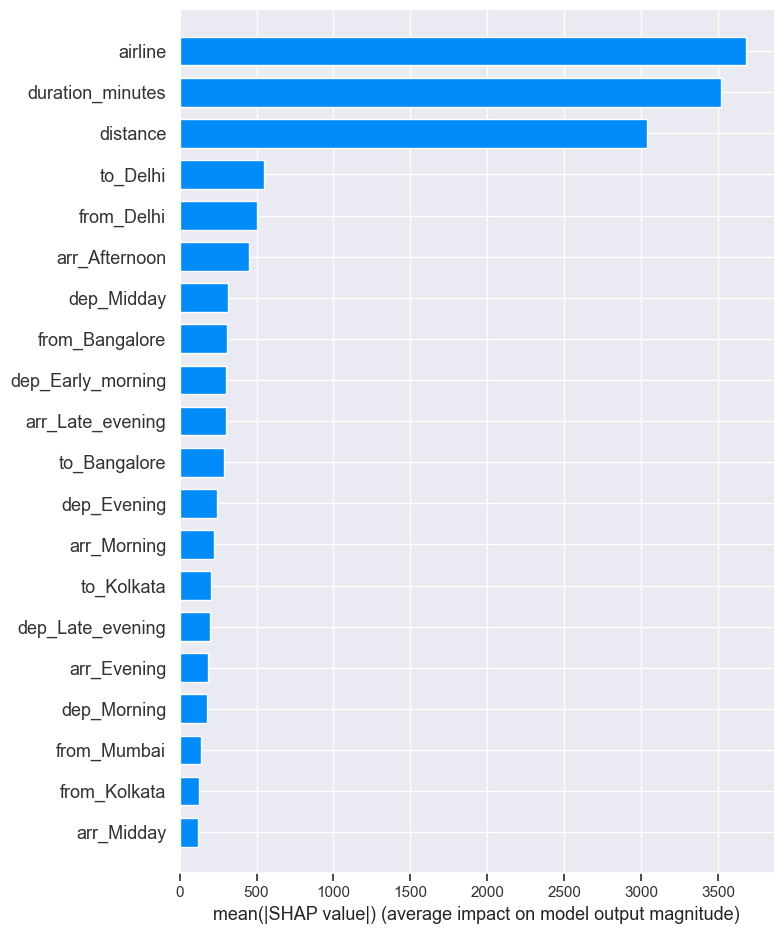

In [80]:
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type='bar')

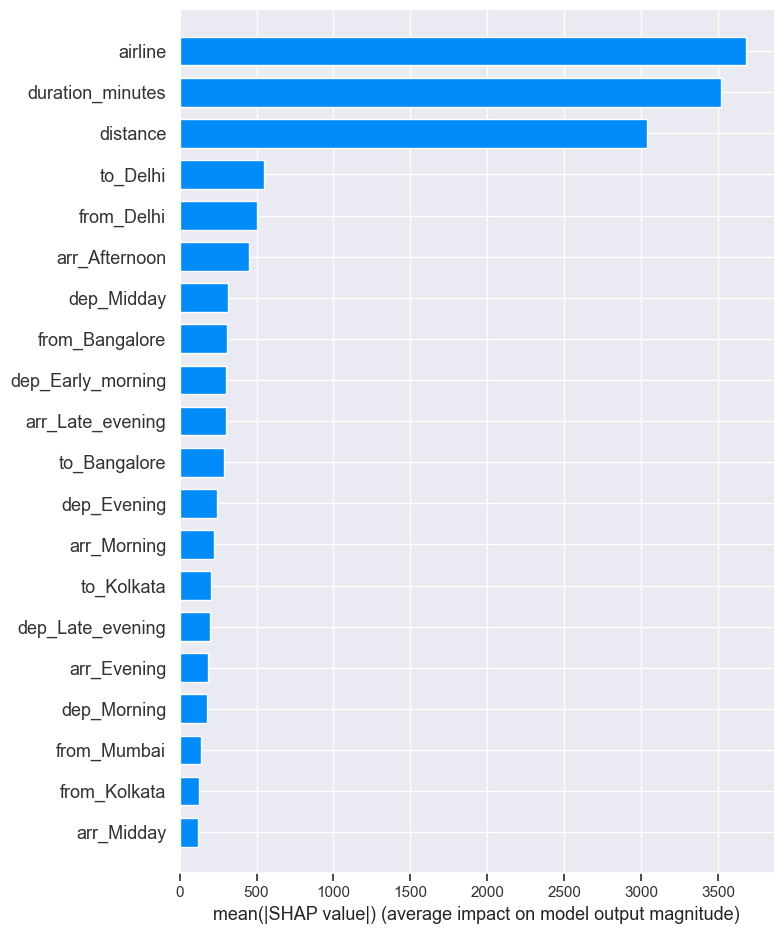

In [87]:
shap_values1 = pickle.load(open('shap_values.pkl','rb'))
shap.summary_plot(shap_values1, X, plot_type='bar')

# **Export with Pickle**

In [50]:
# Export the model 
pickle.dump(model_rf, open('model_components/model_rf.pkl','wb'))

# Export the scaler for numerical values
pickle.dump(scaler, open('model_components/scaler.pkl','wb'))

# Export OntHotEncoders for categorical values
pickle.dump(ohe_X, open('model_components/ohe.pkl','wb'))

# Export LabelEncoder for airline
pickle.dump(le, open('model_components/le.pkl','wb'))

# Export SHAP values
pickle.dump(shap_values, open('model_components/shap_values.pkl','wb'))

# Export dataset
df.to_json('model_components/df.json')


# **Move this to Streamlit**

In [66]:
# Load components
model_rf = pickle.load(open('model_components/model_rf.pkl','rb'))
scaler = pickle.load(open('model_components/scaler.pkl','rb'))
df = pd.read_json('model_components/df.json')
ohe = pickle.load(open('model_components/ohe.pkl','rb'))
le = pickle.load(open('model_components/le.pkl','rb'))

In [78]:
def predict_price(airline, duration, distance, stop, city_from, city_to, dep_time, 
                  arr_time, price=0):

    airline = le.transform([airline])
    
    city_from = "from_" + city_from
    city_to = 'to_' + city_to
    dep_time = "dep_" + dep_time
    arr_time = "arr_" + arr_time
    
    cats = list(itertools.chain(*ohe.categories_))

    new_cat = pd.DataFrame({'to':city_to,
                            'from': city_from,
                            'dep_time': dep_time,
                            'arr_time': arr_time}, index=[0])
    
    new_values_cat = pd.DataFrame(ohe.transform(new_cat), columns = cats, index=[0])
    
    new_num = pd.DataFrame({
      'price': [price],
      'airline':[airline],
      'distance':[distance],
      'duration_minutes':[duration],
      'stop':[stop],
      })

    new_values_num = pd.DataFrame(scaler.transform(new_num), columns = new_num.columns, index=[0])
    new_values_num = new_values_num.drop('price', axis=1) 

    line_to_pred = new_values_num.join(new_values_cat)
    prediction = model_ols.predict(line_to_pred)

    prediction_value = prediction[0].round(2)

    string = f"Estimated flight price is {prediction_value} INR"

    return string



In [79]:
predict_price(airline='Air India', 
              duration=120, 
              distance=1139, 
              stop=0, 
              city_from="Delhi", 
              city_to="Mumbai", 
              dep_time="Evening", 
              arr_time="Late_evening")

'Estimated flight price is 29974.0 INR'